# About the Dataset

The original CORD-19 is a resource of over 1,000,000 scholarly articles, including over 400,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.

In our project, the dataset is sampled from the CORD-19 with size ~10,000 to reduce computation burden.

In [1]:
# import packages
import os
import json
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Load & Pre-processing

In [2]:
# Load Meta data from meta_10k.csv
#data_root = '/content/drive/MyDrive/CORD_19/'
data_root = 'data/'

metadata_path = os.path.join(data_root, 'meta_10k.csv')
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str,
    'doi': str
})

#print(len(meta_df))
#print(meta_df.head())
#print(meta_df.info())

In [3]:
def glob_files(path, f_type=".json"):
    dst = []
    for root, _, files in os.walk(path):
        for f in files:
            if f.endswith(f_type):
                dst.append(os.path.join(root, f))
    return dst

# glob json files
json_dir = os.path.join(data_root, "subset/document_parses/pdf_json/")
#print(json_dir)
json_files = glob_files(json_dir, ".json")

#print("total json files:", len(json_files))

In [4]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)

            self.title = content['metadata']['title']

            #dict_keys(['paper_id', 'metadata', 'abstract', 'body_text',
            #'bib_entries', 'ref_entries', 'back_matter'])


    def __repr__(self):
        return f"{self.paper_id}: {self.title } : {self.abstract[:200]}... {self.body_text[:200]}..."


first_row = FileReader(json_files[0])
#print(first_row)

In [5]:
from tqdm import tqdm

def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data


dict_ = {'paper_id': [], 'publish_time': [], 'doi':[], 'abstract': [], 'body_text': [],
         'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}


for idx, entry in tqdm(enumerate(json_files), total=len(json_files)):
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip

    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0:
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)

    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]

    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])

    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])

    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])

    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])

    # add publish time
    publish_time = meta_data['publish_time'].values[0]
    if len(publish_time) > 4:
        publish_time = datetime.strptime(publish_time, '%Y-%m-%d') 
    elif len(publish_time) == 4:
        publish_time += '-01-01'
        publish_time = datetime.strptime(publish_time, '%Y-%m-%d')
        
    dict_['publish_time'].append(publish_time)

df_covid = pd.DataFrame(dict_, columns=['paper_id', 'publish_time', 'doi', 'abstract', 'body_text',
                                        'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

100%|██████████| 12000/12000 [00:13<00:00, 888.27it/s]


,paper_id,publish_time,doi,abstract,body_text,authors,title,journal,abstract_summary
0,5e0c586f047ff909c8ed3fe171c8975a90608d08,2018-08-30,10.1186/s12985-018-1042-3,Background: Porcine epidemic diarrhea virus (P...,"Porcine epidemic diarrhea virus (PEDV), which ...","Gong, Lang. Lin, Ying. Qin, Jianru. Li,<br...",Neutralizing antibodies against porcine<br>ep...,Virol J,Background: Porcine epidemic diarrhea virus<b...
1,81b2c4bef0f1d7b508ff38e5002e5338860a863e,2021-05-01,10.1007/s42452-021-04589-2,This paper presents an approach to access real...,Underground mining industry is essential to ru...,"RayChowdhury, Ankita. Pramanik, Ankita. Roy...",New approach for localization and smart data<...,SN Appl Sci,This paper presents an approach to access rea...
2,3a33dd3f90004f77dc936e64720d3a17de99b14f,2021-09-27,10.3390/biology10100969,"Citation: Rojo-Tirado, M.A.; Benítez-Muñoz, J....","Due to the SARS-CoV2 pandemic, declared by the...","Rojo-Tirado, Miguel A.. Benítez-Muñoz, José<...",Effect of Different Types of Face Masks on th...,Biology (Basel),"Citation: Rojo-Tirado, M.A.; Benítez-Muñoz,<b..."
3,91ee398ce41826520f17d182c7b1d19083e70541,2022-03-11,10.1007/s11739-022-02955-5,We examined the characteristics of pro-calcito...,Pro-calcitonin (PCT) is a biomarker of bacteri...,"So, Wonhee. Simon, Matthew S.. Choi, Justin...",Characteristics of procalcitonin in<br>hospit...,Intern Emerg Med,We examined the characteristics of<br>pro-cal...
4,0d3bad819324b204c21d460a91c4cbacc536e4d1,2021-03-23,10.1093/infdis/jiab147,Human rhinovirus triggers an innate immune res...,A c c e p t e d M a n u s c r i p t 5\nThe rap...,"Dee, Kieran. Goldfarb, Daniel M. Haney,<br>...",Human rhinovirus infection blocks SARS-CoV-2<...,J Infect Dis,Human rhinovirus triggers an innate immune<br...


In [6]:
#df_covid.info()

In [7]:
df = df_covid
df.dropna(inplace=True)
#df.info()

In [8]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass

    # get the language
    languages.append(lang)

100%|██████████| 8070/8070 [00:13<00:00, 597.68it/s]


In [9]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

df['language'] = languages
df = df[df['language'] == 'en']
#df.info()

Total: 8070

{'de': 20, 'en': 8028, 'es': 13, 'fr': 6, 'id': 1, 'nl': 2}


# Histogram of year / journal

In [10]:
df['publish_year'] = df['publish_time'].dt.year
start_year = 1970
end_year = 2022

mask = (df['publish_year'] >= start_year) & (df['publish_year'] <= end_year)

df = df.loc[mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 9021
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   paper_id          8028 non-null   object        
 1   publish_time      8028 non-null   datetime64[ns]
 2   doi               8028 non-null   object        
 3   abstract          8028 non-null   object        
 4   body_text         8028 non-null   object        
 5   authors           8028 non-null   object        
 6   title             8028 non-null   object        
 7   journal           8028 non-null   object        
 8   abstract_summary  8028 non-null   object        
 9   language          8028 non-null   object        
 10  publish_year      8028 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(9)
memory usage: 721.3+ KB


/var/folders/wt/1v2sp96s4hxcw55n8d5bcw8m0000gn/T/ipykernel_4487/1143009890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publish_year'] = df['publish_time'].dt.year


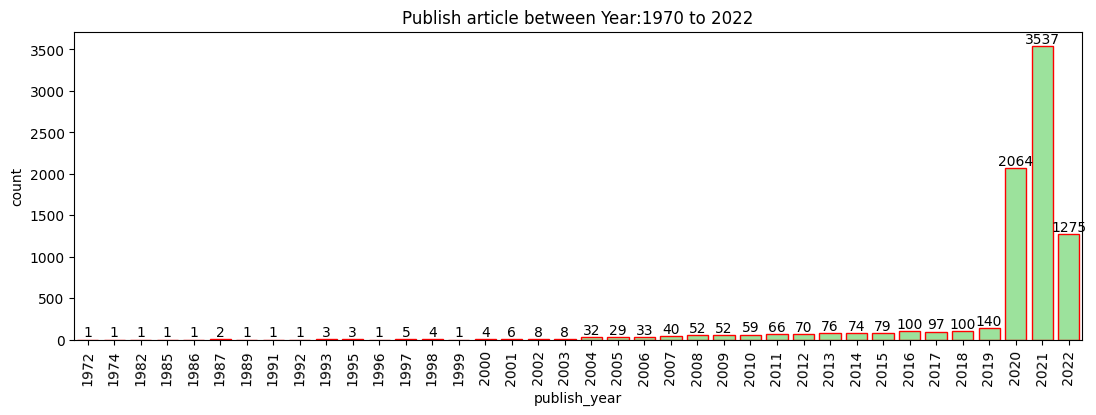

In [11]:
import seaborn as sns

plt.figure(figsize=(13,4))
ax = sns.countplot(x='publish_year', data=df, color='lightgreen', edgecolor='red',)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='x', rotation=88)
plt.title('Publish article between Year:' + str(start_year) + ' to ' + str(end_year))
plt.show()

# Histogram of Journal

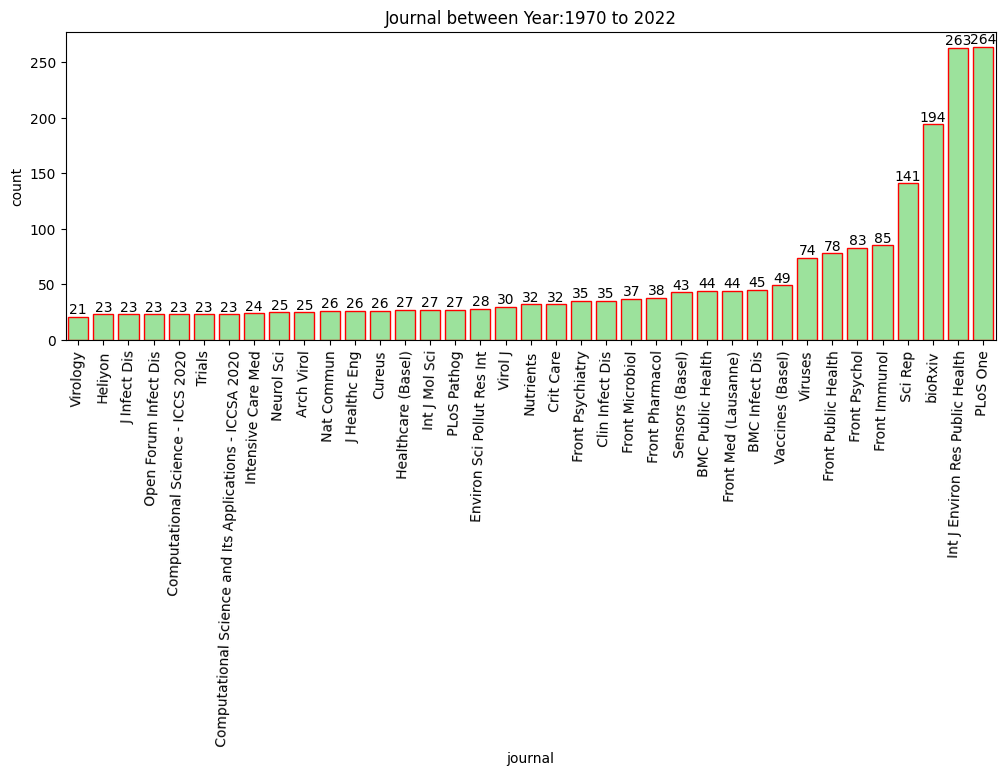

In [12]:
a = df.groupby('journal').filter(lambda x: len(x) > 20)
order = a.journal.value_counts(ascending=True).index

plt.figure(figsize=(12,4))
bx = sns.countplot(data=a, color='lightgreen', edgecolor='red', order=order, x='journal') 
bx.bar_label(bx.containers[0])
bx.tick_params(axis='x', rotation=88)
plt.title('Journal between Year:' + str(start_year) + ' to ' + str(end_year))
plt.show()

# Remove Stop Word

In [13]:
#NLP
import spacy
import string
from spacy.lang.en import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[0:10]

custom_stop_words = [
    'doi','preprint','copyright','peer','reviewed','org','https','et','al','author','figure',
    'rights','reserved','permission','used','using','biorxiv','medrxiv','license','fig','fig.',
    'al.','Elsevier','PMC','CZI', 'are', 'their', 'be',
    'a', 'after', 'also', 'an', 'and', 'as', 'at', 'base', 'between', 'but', 'by', 'did', 'do', 'does', 'during', 'for', 'from', 
    'have', 'has', 'had', 'however',
    'in', 'is', 'it', 'its', 'new', 'of', 'on', 'or', 
    'that', 'the', 'to', 'use', 'using', 'was', 'we', 'were', 'which', 'with', '=', 'br',
    'drug', 'this', 'our', 'may', 'among', 'can', 'these' ,'there', 'been',
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

# Parser
#parser = en_core_sci_lg.load(disable=["tagger","ner"])
#nlp = spacy.load('en_core_web_sm',disable=["tagger","ner"])
nlp = spacy.load('en_core_web_sm',disable=["tagger","parser","ner"]) # Only tokenization and lemmation are performed, POS tagging, NER and syntactic parsing are skipped.
nlp.max_length = 7000000

stopwords = set(stopwords)
punctuations = set(punctuations)
print('len(stopwords):',len(stopwords),'len(punctuations):',len(punctuations), 'typeof(stopwords):', type(stopwords))
p = re.compile('[a-zA-Z]+')

SINGULAR_SUFFIX = [
    ('people', 'person'),
    ('men', 'man'),
    ('wives', 'wife'),
    ('menus', 'menu'),
    ('us', 'us'),
    ('ss', 'ss'),
    ('is', 'is'),
    ("'s", "'s"),
    ('ies', 'y'),
    ('ies', 'y'),
    ('es', 'e'),
    ('s', '')
]

def singularize_word(word):
    for suffix, singular_suffix in SINGULAR_SUFFIX:
        if word.endswith(suffix):
            return word[:-len(suffix)] + singular_suffix
    return word

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma != '-PORN-' else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if len(word) > 2 
                and p.match(word)
                and word.isalpha() 
                and word not in stopwords 
                and word not in punctuations 
                and word in nlp.vocab]
    #mytokens = [word for word in mytokens if detect(word) == 'en' and word.isalpha()]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

tqdm.pandas()
df['procesed_title'] = df['title'].progress_apply(spacy_tokenizer)
df['procesed_abstract'] = df['abstract'].progress_apply(spacy_tokenizer)
df['procesed_text'] = df['body_text'].progress_apply(spacy_tokenizer)

df['procesed_title_list'] = df['procesed_title'].str.split()
df['procesed_abstract_list'] = df['procesed_abstract'].str.split()
df['procesed_text_list'] = df['procesed_text'].str.split()


df['all_text_list'] = df['procesed_title_list'] + df['procesed_abstract_list'] + df['procesed_text_list']

df.head()

len(stopwords): 355 len(punctuations): 32 typeof(stopwords): <class 'set'>


100%|██████████| 8028/8028 [03:14<00:00, 41.26it/s]


,paper_id,publish_time,doi,abstract,body_text,authors,title,journal,abstract_summary,language,publish_year,procesed_title,procesed_abstract,procesed_text,procesed_title_list,procesed_abstract_list,procesed_text_list,all_text_list
0,5e0c586f047ff909c8ed3fe171c8975a90608d08,2018-08-30,10.1186/s12985-018-1042-3,Background: Porcine epidemic diarrhea virus (P...,"Porcine epidemic diarrhea virus (PEDV), which ...","Gong, Lang. Lin, Ying. Qin, Jianru. Li,<br...",Neutralizing antibodies against porcine<br>ep...,Virol J,Background: Porcine epidemic diarrhea virus<b...,en,2018,porcine epidemic diarrhea virus block virus at...,background porcine epidemic diarrhea virus pat...,porcine epidemic diarrhea virus alphacoronavir...,"[porcine, epidemic, diarrhea, virus, block, vi...","[background, porcine, epidemic, diarrhea, viru...","[porcine, epidemic, diarrhea, virus, alphacoro...","[porcine, epidemic, diarrhea, virus, block, vi..."
1,81b2c4bef0f1d7b508ff38e5002e5338860a863e,2021-05-01,10.1007/s42452-021-04589-2,This paper presents an approach to access real...,Underground mining industry is essential to ru...,"RayChowdhury, Ankita. Pramanik, Ankita. Roy...",New approach for localization and smart data<...,SN Appl Sci,This paper presents an approach to access rea...,en,2021,approach localization smart transmission insid...,paper present approach access real time underg...,underground industry essential human advanceme...,"[approach, localization, smart, transmission, ...","[paper, present, approach, access, real, time,...","[underground, industry, essential, human, adva...","[approach, localization, smart, transmission, ..."
2,3a33dd3f90004f77dc936e64720d3a17de99b14f,2021-09-27,10.3390/biology10100969,"Citation: Rojo-Tirado, M.A.; Benítez-Muñoz, J....","Due to the SARS-CoV2 pandemic, declared by the...","Rojo-Tirado, Miguel A.. Benítez-Muñoz, José<...",Effect of Different Types of Face Masks on th...,Biology (Basel),"Citation: Rojo-Tirado, M.A.; Benítez-Muñoz,<b...",en,2021,,effect different types face masks cardiovascul...,pandemic world health health policy worldwide ...,[],"[effect, different, types, face, masks, cardio...","[pandemic, world, health, health, policy, worl...","[effect, different, types, face, masks, cardio..."
3,91ee398ce41826520f17d182c7b1d19083e70541,2022-03-11,10.1007/s11739-022-02955-5,We examined the characteristics of pro-calcito...,Pro-calcitonin (PCT) is a biomarker of bacteri...,"So, Wonhee. Simon, Matthew S.. Choi, Justin...",Characteristics of procalcitonin in<br>hospit...,Intern Emerg Med,We examined the characteristics of<br>pro-cal...,en,2022,procalcitonin clinical antibiotic procalcitonin,pro patient cohort clinical outcome antibiotic...,pro biomarker bacterial infection useful guide...,"[procalcitonin, clinical, antibiotic, procalci...","[pro, patient, cohort, clinical, outcome, anti...","[pro, biomarker, bacterial, infection, useful,...","[procalcitonin, clinical, antibiotic, procalci..."
4,0d3bad819324b204c21d460a91c4cbacc536e4d1,2021-03-23,10.1093/infdis/jiab147,Human rhinovirus triggers an innate immune res...,A c c e p t e d M a n u s c r i p t 5\nThe rap...,"Dee, Kieran. Goldfarb, Daniel M. Haney,<br>...",Human rhinovirus infection blocks SARS-CoV-2<...,J Infect Dis,Human rhinovirus triggers an innate immune<br...,en,2021,rhinovirus infection block replication respira...,human rhinovirus trigger innate immune respons...,rapid spread impact global health importance v...,"[rhinovirus, infection, block, replication, re...","[human, rhinovirus, trigger, innate, immune, r...","[rapid, spread, impact, global, health, import...","[rhinovirus, infection, block, replication, re..."


# Map-Reduce 

In [14]:
import csv
import re
from collections import defaultdict
from functools import reduce

# Sample data: list of documents (each document is a string)
documents_MR = []
with open(metadata_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        documents_MR.append(row[4])  # Assuming the 4th column is at index 3 (0-based indexing)
        documents_MR.append(row[9])  # Assuming the 9th column is at index 4 (0-based indexing)


# Specify the words to include in the stoplist
stop_words_lower = [word.lower() for word in custom_stop_words]

# Mapper function
def map_function(documents_MR):
    # Split the document into words and assign an ID to each word
    for idx, word in enumerate(documents_MR.split(), start=1):
      yield (word.lower(), 1)

# Step 1: Map phase
mapped = []
for documents_MR in documents_MR:
    mapped.extend(map_function(documents_MR))

# Step 2: Shuffle and sort phase (group by key)
shuffled = defaultdict(list)
for word, count in mapped:
    shuffled[word].append(count)

# Step 3: Reduce phase
reduced = {}
for word, counts in shuffled.items():
    reduced[word] = reduce(lambda x, y: x + y, counts)

# Step 4: Merge the counts of words with uppercase and lowercase versions together
merged_counts = defaultdict(int)
for word, count in reduced.items():
    merged_word = re.sub(r'[^a-zA-Z0-9]', '', word)
    # Remove non-alphanumeric characters
    merged_counts[merged_word.lower()] += count

# Step 5.1: filter out the stop words
filtered = {word: count for word, count in reduced.items() if word.lower() not in stop_words_lower}

# Step 5.2: Sort the filtered words by count in descending order
sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
sorted_words_unfilter = sorted(reduced.items(), key=lambda x: x[1], reverse=True)

# Step 5.3: Get the top 50 prevalent words
top50_filtered = sorted_words[:50]
top50_unfilter = sorted_words_unfilter[:80]

# Step 6.1: Print the table of the top 50 prevalent words without stop words list
#print("Top 80 Prevalent Words without stopwords:")
#print(f"{'ID':<4}{'Word':<20}{'Count'}")
#print("-----------------------------")
#for idx, (word, count) in enumerate(top50_unfilter, start=1):
#    print(f"{idx:<4}{word:<20}{count}")
#print("\n"+"\n")

# Step 6.2: Print the table of the top 50 prevalent words with IDs
print("Top 50 Prevalent Words:")
print(f"{'ID':<4}{'Word':<20}{'Count'}")
print("-----------------------------")
for idx, (word, count) in enumerate(top50_filtered, start=1):
    print(f"{idx:<4}{word:<20}{count}")


Top 50 Prevalent Words:
ID  Word                Count
-----------------------------
1   covid-19            10343
2   patients            7203
3   study               5251
4   health              4244
5   data                3600
6   disease             3458
7   sars-cov-2          3371
8   not                 3184
9   clinical            2962
10  pandemic            2923
11  more                2844
12  infection           2803
13  respiratory         2490
14  results             2486
15  associated          2484
16  coronavirus         2449
17  risk                2438
18  virus               2395
19  analysis            2342
20  all                 2340
21  than                2267
22  most                2246
23  viral               2192
24  other               2187
25  such                2182
26  model               2127
27  severe              2101
28  two                 2019
29  results:            1971
30  care                1970
31  different           1937
32  human       

# Association Analysis

In [15]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import gensim.downloader as api

def get_target_document_index(X,token_list,target_word_list,model_name='glove-wiki-gigaword-100',top_feature=20,top_document=100):
    
    '''
    Compare each target word to all token used as feature and find the top related document index.
    Using gensim model for semantic analysis by default using glove-wiki-gigaword-100.
    Return a dictionary of most related documents index for each target word.
    
    Argument:
    
    - X:
    A numpy array of characteristic matrix with row as number of feature and column as number of document. 
    Recommend to use the token count as feature.
    
    - token_list:
    A list of string that use to build the feature of the characteristic matrix.
    
    - target_word_list:
    A list of string that all token compare with.
    Each target word can be any string that is not in the token_list but must be in the model.
    
    - model_name:
    A string of model name that use to give a similarity of score between the target worad and the token used.
    Must be a valid model name that can be called by using Gensim API.
    
    - top_feature:
    An integer number of most related features compare with the target word.
    
    - top_document:
    An integer number of most related documents compare with the target word.
    '''
    
    print(f'Using Model: {model_name}\n')
    
    model = api.load(model_name)
    
    # Check all target words are in the model
    for target_word in target_word_list:
        if target_word not in model:
            ValueError(f'Argument: target_word is not in model {model_name}')
            
    # Check input top_feature and token_list size
    if len(token_list) <= top_feature:
        print(f'Warning: Argument top_feature ({top_feature}) is greater than or equal to token_list size ({len(token_list)})')
        print('No feature filtering will be performed.\n')
        
    # Check the proportion of token that is not in model.
    token_not_exist = 0
    for i in token_list:
        if i not in model:
            token_not_exist += 1
            
    print(f'Token not in model: {token_not_exist}/{len(token_list)} ({round(token_not_exist/(len(token_list))*100,1)}%)')
    

    # Create a result dictionary for all target words
    
    result_dict = {}
    for i in range(0,len(target_word_list)):
        
        target_word = target_word_list[i]
        print(f'Comparing target word {i}/{len(target_word_list)}: {target_word}')
        
        token_score_df = get_target_word_similarity(model,token_list,target_word)
        doc_to_keep = get_most_similar_document(X,token_score_df,token_list,top_feature=top_feature,top_document=top_document)
        result_dict[target_word] = doc_to_keep
        
    return result_dict

        
def get_target_word_similarity(model,token_list,target_word):
    '''
    Return the similarity score for all tokens used as feature compare with the target word.
    Using cosine similarity by default.
    '''
    
    target_word_feature = model[target_word]
    target_word_norm = np.linalg.norm(target_word_feature)
    
    # List of tokne used to build feature
    # token_list = list(vectorizer.get_feature_names_out())
    
    token_score_list = []
    
    # token_exist = 0
    # token_not_exist = 0
    
    # Use cosine similarity between the target word and the token using feature created from gensim model.
    for token in token_list:
        if token in model:
            token_norm = np.linalg.norm(model[token])
            score = (model[token] @ target_word_feature.T)/(token_norm*target_word_norm)
            # token_exist += 1
        else:
            score = None
            # token_not_exist += 1
            
        token_score_list.append(score)

    # print(f'Number of token exists in model:{token_exist}/{token_exist+token_not_exist} ({round(token_exist/(token_exist+token_not_exist)*100,1)}%)')

    df = pd.DataFrame({'token':token_list,'score':token_score_list})
    df = df.sort_values(by=['score'],ascending=False)
    df = df.fillna(0)
    
    return df

    
def get_most_similar_document(X,token_score_df,token_list,top_feature=20,top_document=100):
    
    '''
    - X:
    A 2D numpy array characteristic matrix with number of token as row, number of document as column.
    Prefer using count of token occurrence as feature.
    
    - token_score_df:
    A pandas dataframe with the similarity score for each token compare with the target word.
    
    - top_feature:
    An integer number of most related features compare with the target word.
    
    - top_document:
    An integer number of most related documents compare with the target word.
    
    Return a list of document number with zero based index.
    The list is truncated by the size of top_document.
    The document index is in the descending order of similarity score followed by the document index in the characteristic matrix.
    '''
    
    keep_feature = list(token_score_df.head(top_feature)['token'])
    
    # Loop through all token in characteristic matrix to find the feature to keep
    token_index_list = []
    for i in range(0,len(token_list)):
        if token_list[i] in keep_feature:
            token_index_list.append(i)
            
    # Filter to only contain the most related features
    X_modify = X[token_index_list,:]
    
    # Sum all remaining feature values to create a score for each document
    doc_score = np.sum(X_modify,axis=0)
    doc_rank = ss.rankdata(doc_score,method='min')
    
    distinct_rank = list(set(doc_rank))
    distinct_rank.sort()
    
    doc_to_keep = []

    # When multiple documents have the same rank, it may exceed the number of top document limit.
    # Put the document with the lowest rank into the list first.
    # Cap the list size with the number of top document limit.
    for j in distinct_rank:

        for i in range(0,len(doc_rank)):
            rank = doc_rank[i]

            if rank == j and len(doc_to_keep) < top_document:
                doc_to_keep.append(i)
                if len(doc_to_keep) >= top_document:
                    break

    return doc_to_keep

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

feature_size = 2**12
count_vectorizer = CountVectorizer(max_features=feature_size)
X_count = count_vectorizer.fit_transform(df['procesed_text'].values).toarray().T

In [17]:
#target_word_list = ['vaccination', 'good', 'result'] # not in feature but in model
target_word_list = ['vaccine', 'pandemic', 'respiratory'] # not in feature but in model

if len(target_word_list) > 0:
    token_list = list(count_vectorizer.get_feature_names_out())
    index_dict = get_target_document_index(X_count,token_list,target_word_list)
    interested_list = list()
    for key in index_dict:
        interested_list += index_dict[key]
    print(len(interested_list))
    df = df.iloc[interested_list]

Using Model: glove-wiki-gigaword-100

Token not in model: 209/3696 (5.7%)
Comparing target word 0/3: vaccine
Comparing target word 1/3: pandemic
Comparing target word 2/3: respiratory
300


# Association Rule (LDA)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siusun0033/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Coherence Score:  0.28507274500600954
[(0,
  '0.019*"study" + 0.013*"student" + 0.009*"research" + 0.009*"social" + '
  '0.008*"time" + 0.008*"learn" + 0.008*"high" + 0.007*"effect" + '
  '0.007*"support" + 0.006*"role"'),
 (1,
  '0.016*"information" + 0.014*"food" + 0.011*"trust" + 0.010*"label" + '
  '0.010*"study" + 0.010*"type" + 0.010*"world" + 0.010*"value" + '
  '0.009*"application" + 0.008*"time"'),
 (2,
  '0.011*"sample" + 0.011*"government" + 0.010*"high" + 0.010*"study" + '
  '0.010*"strategy" + 0.009*"supply" + 0.008*"market" + 0.008*"increase" + '
  '0.008*"model" + 0.007*"cost"'),
 (3,
  '0.022*"model" + 0.018*"network" + 0.013*"system" + 0.012*"method" + '
  '0.011*"node" + 0.010*"process" + 0.009*"different" + 0.008*"time" + '
  '0.008*"value" + 0.008*"algorithm"')]
<bound method LdaModel.top_topics of <gensim.models.ldamodel.LdaModel object at 0x3a88d8c70>>


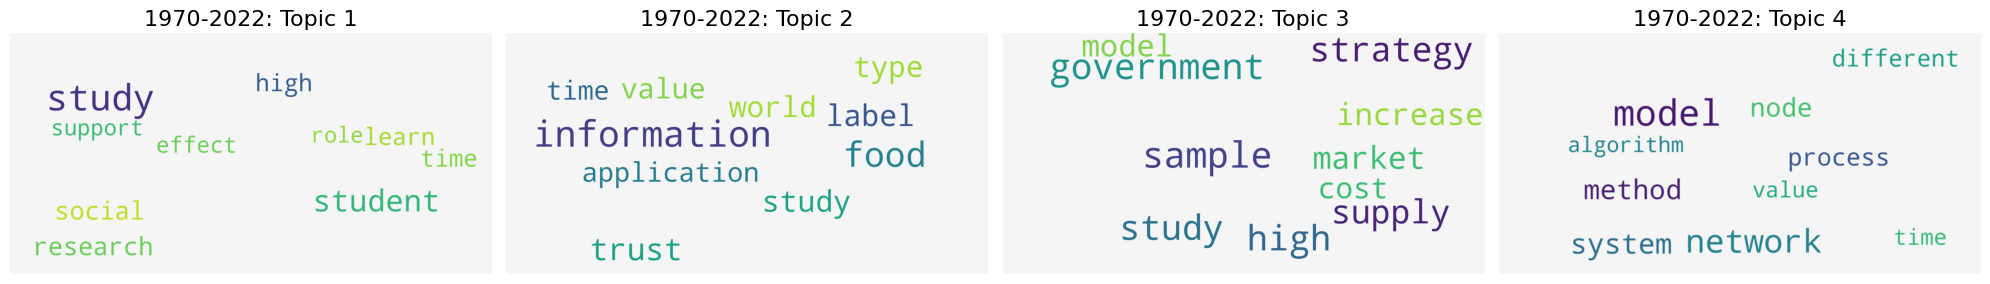

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.092300  0.086574       1        1  33.080873
3      0.007861 -0.058738       2        1  28.119203
1     -0.032244 -0.078565       3        1  19.460420
2      0.116683  0.050729       4        1  19.339504, topic_info=          Term         Freq        Total Category  logprob  loglift
177    network  2021.000000  2021.000000  Default  30.0000  30.0000
728       food  1099.000000  1099.000000  Default  29.0000  29.0000
964    student  1687.000000  1687.000000  Default  28.0000  28.0000
178       node  1185.000000  1185.000000  Default  27.0000  27.0000
881      trust   887.000000   887.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
267     system   458.921370  2457.497527   Topic4  -5.0590  -0.0350
206    present   398.975660  1516.109957   Topic4  -5.1989   0.3080
61   different   408.796123  2333.942933   Topic4  -5.1746  -0.0991
254      state   349.192018  1171.389789   Topic4  -5.3322   0.4327
297   analysis   368.172880  1923.577912   Topic4  -5.2793  -0.0104

[325 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1564      3  0.010268  ablation
1564      4  0.985727  ablation
0         1  0.387522    access
0         2  0.083445    access
0         3  0.510568    access
...     ...       ...       ...
291       1  0.180039     world
291       2  0.097763     world
291       3  0.705639     world
291       4  0.016455     world
1593      4  0.990979      zinc

[818 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [18]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


# Create Dictionary
id2word = corpora.Dictionary(df['all_text_list'])
# Create Corpus
texts = df['all_text_list']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Set number of topics
num_topics = 4
# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha='auto', per_word_topics=True)
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['all_text_list'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

# Prepare Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                    width=4000,
                    height=2000,
                    max_words=10,
                    prefer_horizontal=1.0,
                    background_color='whitesmoke'
                )

topics = lda_model.show_topics(formatted=False)
# Print the keywords for each topic
pprint(lda_model.print_topics())
print(lda_model.top_topics)

fig, axes = plt.subplots(1, num_topics, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(cloud)
    plt.gca().set_title(str(start_year) + '-' + str(end_year) + ': Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.imshow(cloud, interpolation='bilinear')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
vis

# Prepare for Association Mining 

In [19]:
from mlxtend.frequent_patterns import apriori, association_rules 
from mlxtend.preprocessing import TransactionEncoder

min_support = 0.6
mine_col = 'all_text_list'

# Pre-processing
te = TransactionEncoder()
te_ary = te.fit (df['all_text_list']).transform(df['all_text_list'])
df_processd_text = pd.DataFrame (te_ary, columns=te.columns_)
print(df_processd_text)

     abdominal  ablation  abortion  abroad  absent  abstract  academia  \
0        False     False     False   False   False     False     False   
1        False     False     False   False   False     False     False   
2        False     False     False   False   False     False     False   
3        False     False     False   False   False     False     False   
4        False     False     False   False   False     False     False   
..         ...       ...       ...     ...     ...       ...       ...   
295      False     False     False   False   False     False     False   
296      False     False     False   False   False     False     False   
297      False     False     False   False   False     False     False   
298      False     False     False   False    True     False      True   
299      False     False     False   False   False     False     False   

     academic  accelerated  acceptability  ...   year  years  yeast  yellow  \
0       False        False      

In [20]:
def find_association_rules(frq_items):
    # Collecting the inferred rules in a dataframe 
    rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
    rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x)) 
    rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x)) 
    rules = rules.sort_values(['lift', 'antecedent_len', 'consequents_len', 'confidence'], ascending=[False, False, False, False]) 
    return rules 

In [54]:
def draw_graph(rules, rules_to_show, topics, title):
     import networkx as nx  
     G1 = nx.DiGraph()
     color_map=[]
     strs = []
     for i in range(len(topics)):
         strs += dict(topics[i][1])
     
     for z in range(rules_to_show):
          rand_index = np.random.randint(0, len(rules) - 1)
          for a in rules.iloc[rand_index]['antecedents']:
               G1.add_nodes_from([a])
               G1.add_edge(a, rules.iloc[rand_index]['antecedents'], weight = 2)
       
          for c in rules.iloc[i]['consequents']:
               G1.add_nodes_from([c])
               G1.add_edge(rules.iloc[rand_index]['consequents'], c, weight=2)

          for node in G1:
               found_a_string = False
               for item in strs:
                    if node==item:
                         found_a_string = True
       
                    if found_a_string:
                         color_map.append('yellow')
                    else:
                         color_map.append('green')       


     edges = G1.edges()
     pos = nx.spring_layout(G1, k=16, scale=1)
     plt.figure(figsize=(13,7))
     nx.draw_networkx(G1, pos, arrows=True, with_labels=True, node_color='lightblue', node_size=2500)            
     plt.title(title)
     plt.show()

In [49]:
def draw_catgraph(rules, rules_to_show, topics, title):
    N = 50
    x = rules["antecedents"]
    y = rules["consequents"]

    colors = np.random.rand(N)
    area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
    plt.figure(figsize=(13,7))
    plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.title(title)
    plt.show()

# Association Rule (FP Growth)

    support     itemsets
0  0.900000  (different)
1  0.883333       (high)
2  0.866667       (time)
3  0.863333       (find)
4  0.860000     (follow)
                     antecedents                 consequents   support  \
8214              (time, change)  (find, different, present)  0.603333   
8203  (find, different, present)              (time, change)  0.603333   
8206     (time, find, different)           (change, present)  0.603333   
8211           (change, present)     (time, find, different)  0.603333   
6728              (low, present)          (level, different)  0.603333   
...                          ...                         ...       ...   
8587                      (find)                     (order)  0.633333   
7124         (different, method)                     (study)  0.616667   
7129                     (study)         (different, method)  0.616667   
3428                      (case)                      (high)  0.706667   
3429                      (high)    

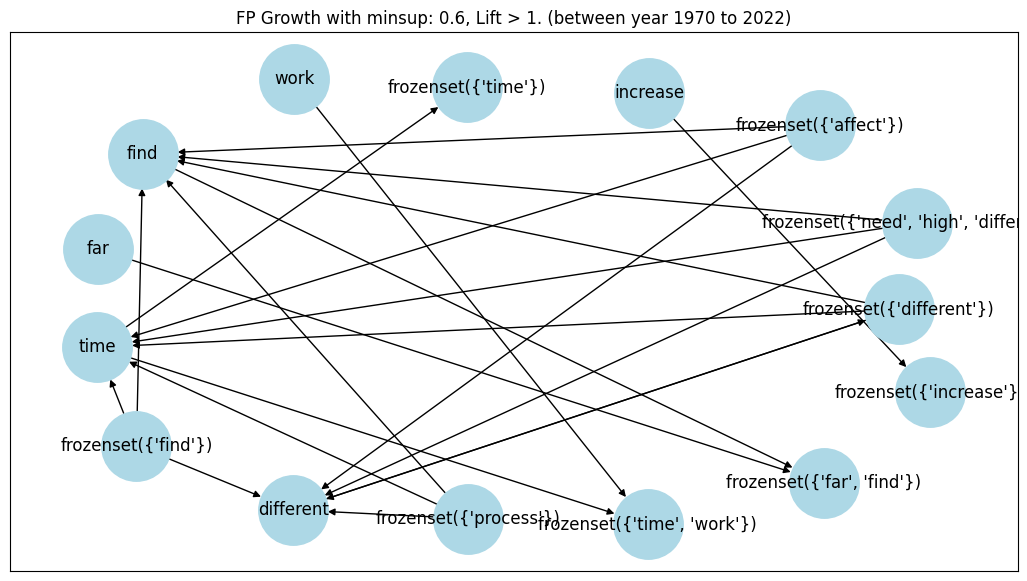

In [55]:
from mlxtend.frequent_patterns import fpgrowth

frq_items_fp = fpgrowth(df_processd_text, min_support=min_support, use_colnames=True)
print(frq_items_fp.head())
rules_fp = find_association_rules(frq_items_fp)
print(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']]) 
if len(rules_fp) > 0:
    #draw_catgraph (rules_fp, 10, topics, 'FP Growth with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')
    draw_graph (rules_fp, 5, topics, 'FP Growth with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')

# Association Rule (Apriori Algorithm)

    support     itemsets
0  0.666667     (affect)
1  0.760000   (analysis)
2  0.690000   (approach)
3  0.606667  (available)
4  0.800000       (case)
                     antecedents                 consequents   support  \
9602              (time, change)  (find, different, present)  0.603333   
9591  (find, different, present)              (time, change)  0.603333   
9594     (time, find, different)           (change, present)  0.603333   
9599           (change, present)     (time, find, different)  0.603333   
7934              (low, present)          (level, different)  0.603333   
...                          ...                         ...       ...   
375                       (find)                     (order)  0.633333   
2676         (method, different)                     (study)  0.616667   
2677                     (study)         (method, different)  0.616667   
82                        (case)                      (high)  0.706667   
83                        (high)    

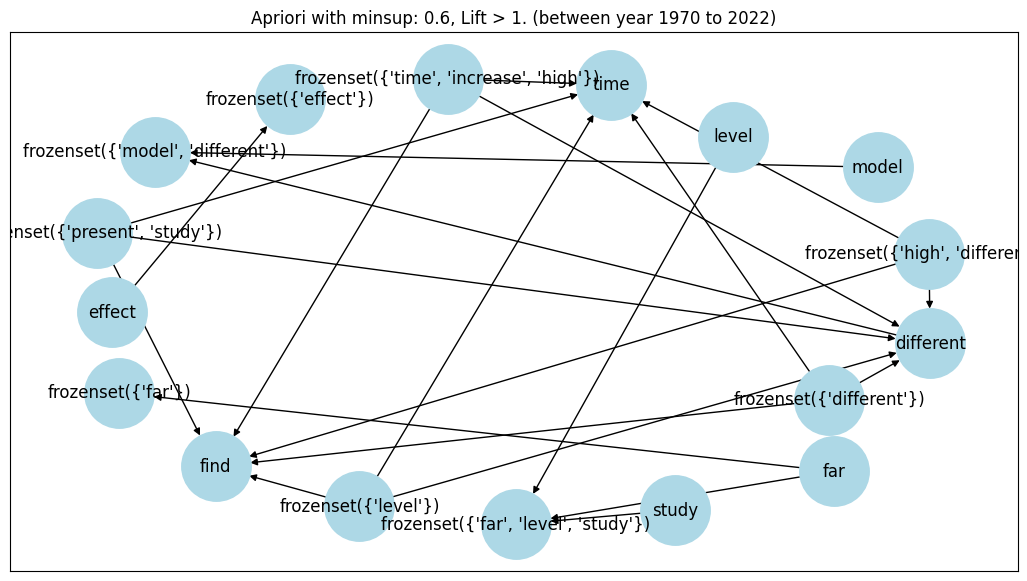

In [57]:
# Building the model 
frq_items_ap = apriori(df_processd_text, min_support = min_support, use_colnames = True) 
print(frq_items_ap.head())
rules_ap = find_association_rules(frq_items_ap)
print(rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']]) 
if len(rules_ap) > 0:
    #draw_catgraph (rules_ap, 10, topics, 'Apriori with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')
    draw_graph (rules_ap, 5, topics, 'Apriori with minsup: ' + str(min_support) + ', Lift > 1. (between year ' + str(start_year) + ' to ' + str(end_year) + ')')